In [127]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay
from statsmodels.graphics.tsaplots import plot_pacf

<h2>1. Data ARE-Historical-Data-final

In [128]:
# Import data
df = pd.read_csv('ARE-Historical-Data-final.csv', index_col='Date', parse_dates=True)
df = df.iloc[::-1]
df1=df.reset_index()['Price']

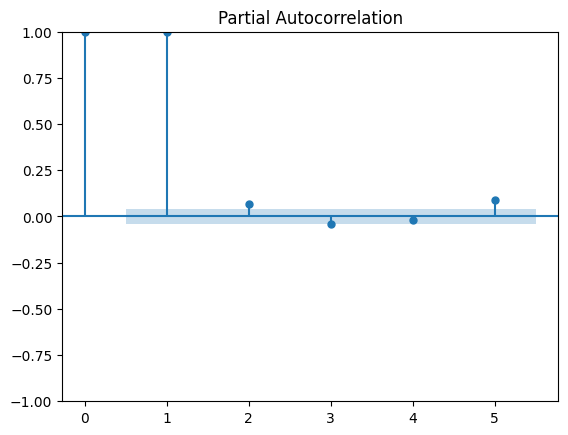

In [129]:
# Kiểm tra sự tương quan một phần PAFC
plot_pacf(df1, lags=5)
plt.show()

In [130]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [131]:
# Chia thành các tập train, test, validation
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [132]:
# Hàm tạo dữ liệu cho mô hình
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [133]:
# Thiết lập thông số mô hình
lookback = 5
horizon = 2
n_features = 1

In [134]:
# Tạo dữ liệu cho mô hình
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [135]:
# Xây dựng mô hình NNAR
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [136]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
40/40 - 3s - loss: 0.0260 - val_loss: 0.0375 - 3s/epoch - 84ms/step
Epoch 2/50
40/40 - 0s - loss: 0.0022 - val_loss: 0.0024 - 204ms/epoch - 5ms/step
Epoch 3/50
40/40 - 0s - loss: 3.7941e-04 - val_loss: 0.0038 - 217ms/epoch - 5ms/step
Epoch 4/50
40/40 - 0s - loss: 3.0952e-04 - val_loss: 0.0038 - 201ms/epoch - 5ms/step
Epoch 5/50
40/40 - 0s - loss: 2.9110e-04 - val_loss: 0.0025 - 201ms/epoch - 5ms/step
Epoch 6/50
40/40 - 0s - loss: 2.8930e-04 - val_loss: 0.0025 - 200ms/epoch - 5ms/step
Epoch 7/50
40/40 - 0s - loss: 2.7460e-04 - val_loss: 0.0023 - 202ms/epoch - 5ms/step
Epoch 8/50
40/40 - 0s - loss: 2.6444e-04 - val_loss: 0.0020 - 201ms/epoch - 5ms/step
Epoch 9/50
40/40 - 0s - loss: 2.6196e-04 - val_loss: 0.0017 - 204ms/epoch - 5ms/step
Epoch 10/50
40/40 - 0s - loss: 2.5874e-04 - val_loss: 0.0018 - 203ms/epoch - 5ms/step
Epoch 11/50
40/40 - 0s - loss: 2.5617e-04 - val_loss: 0.0016 - 202ms/epoch - 5ms/step
Epoch 12/50
40/40 - 0s - loss: 2.4783e-04 - val_loss: 0.0016 - 201ms/epoc

In [137]:
# Dự đoán trên 2 tập X_test và X_val
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

14/14 [==============================] - 0s 2ms/step


In [138]:
# Đánh giá độ chính xác
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.03970254466662665
Testing RMSE: 0.03461655636989492
Testing MAE: 0.02498227291802922
Validation MAE: 0.030294305330178368
Testing MAPE: 4.335208222176928
Validation MAPE: 5.759704461038258


In [139]:
# Scaler lại các giá trị
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [140]:
# Tạo một danh sách mới
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [141]:
# Dự đoán 30 ngày tiếp theo
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


In [142]:
# Trích xuất giá trị dự đoán vào danh sách mới
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

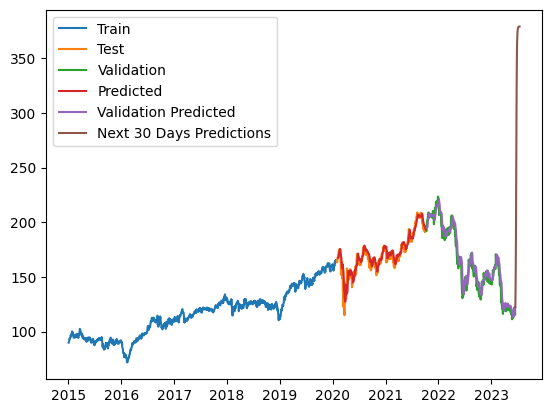

In [143]:
# Tạo danh sách ngày cho trục x
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Vẽ biểu đồ
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price Predictions')
plt.legend()
plt.show()

<h2>2. Data ARI-Historical-Data-final

In [144]:
# Import data
df = pd.read_csv('ARI-Historical-Data-final.csv', index_col='Date', parse_dates=True)
df = df.iloc[::-1]
df1=df.reset_index()['Price']

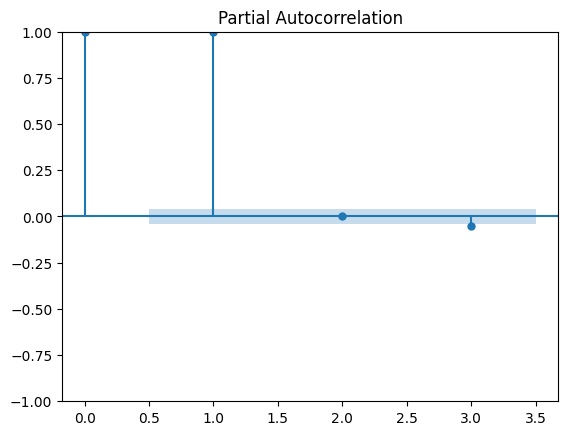

In [145]:
# Kiểm tra sự tương quan một phần PAFC
plot_pacf(df1, lags=3)
plt.show()

In [146]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [147]:
# Chia thành các tập train, test, validation
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [148]:
# Hàm tạo dữ liệu cho mô hình
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [149]:
# Chọn các giá trị lookback, horizon, n_features
lookback = 3
horizon = 1
n_features = 1

In [150]:
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [151]:
# Xây dựng mô hình NNAR
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [152]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
40/40 - 4s - loss: 0.2658 - val_loss: 0.0328 - 4s/epoch - 111ms/step
Epoch 2/50
40/40 - 0s - loss: 0.0025 - val_loss: 0.0174 - 192ms/epoch - 5ms/step
Epoch 3/50
40/40 - 0s - loss: 6.7042e-04 - val_loss: 0.0180 - 233ms/epoch - 6ms/step
Epoch 4/50
40/40 - 0s - loss: 6.0883e-04 - val_loss: 0.0173 - 189ms/epoch - 5ms/step
Epoch 5/50
40/40 - 0s - loss: 5.8382e-04 - val_loss: 0.0164 - 187ms/epoch - 5ms/step
Epoch 6/50
40/40 - 0s - loss: 5.5656e-04 - val_loss: 0.0155 - 182ms/epoch - 5ms/step
Epoch 7/50
40/40 - 0s - loss: 5.3566e-04 - val_loss: 0.0154 - 176ms/epoch - 4ms/step
Epoch 8/50
40/40 - 0s - loss: 5.0443e-04 - val_loss: 0.0140 - 180ms/epoch - 5ms/step
Epoch 9/50
40/40 - 0s - loss: 4.7782e-04 - val_loss: 0.0131 - 181ms/epoch - 5ms/step
Epoch 10/50
40/40 - 0s - loss: 4.5692e-04 - val_loss: 0.0128 - 183ms/epoch - 5ms/step
Epoch 11/50
40/40 - 0s - loss: 4.3615e-04 - val_loss: 0.0110 - 188ms/epoch - 5ms/step
Epoch 12/50
40/40 - 0s - loss: 4.0654e-04 - val_loss: 0.0102 - 186ms/epo

In [153]:
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

14/14 [==============================] - 0s 2ms/step


In [154]:
# Đánh giá độ chính xác
y_test_nonzero = y_test[y_test != 0]
y_pred_nonzero = y_pred[y_test != 0]

valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test_nonzero - y_pred_nonzero) / y_test_nonzero)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.04825714461230854
Testing RMSE: 0.0663185096878313
Testing MAE: 0.04770023933495698
Validation MAE: 0.03933302789849316
Testing MAPE: 16.25452506547037
Validation MAPE: 9.403209573465976


In [155]:
# Scaler lại các giá trị
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [156]:
# Tạo một danh sách mới
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [157]:
# Dự đoán 30 ngày tiếp theo
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
# next30days_predictions = np.array(next30days_predictions).reshape(-1, 1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


In [158]:
# Trích xuất giá trị dự đoán vào danh sách mới
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

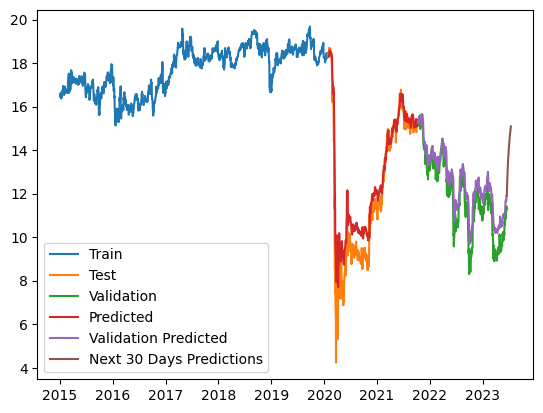

In [159]:
# Tạo danh sách ngày cho trục x
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Vẽ biểu đồ
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price Predictions')
plt.legend()
plt.show()

<h2>3. Data MAA-Historical-Data-final

In [160]:
# Import data
df = pd.read_csv('MAA-Historical-Data-final.csv', index_col='Date', parse_dates=True)
df = df.iloc[::-1]
df2=df.reset_index()['Price']

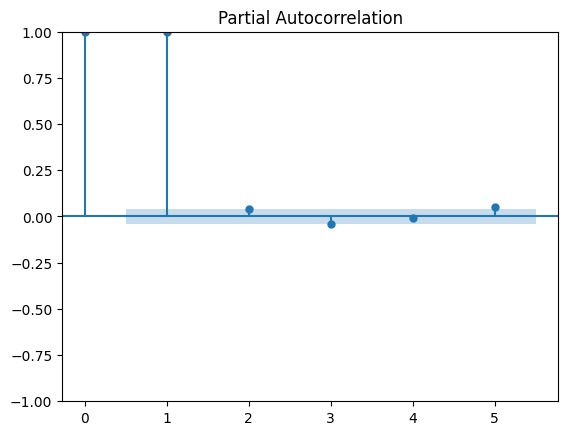

In [161]:
# Kiểm tra sự tương quan một phần PAFC
plot_pacf(df2, lags=5)
plt.show()

In [162]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df2=scaler.fit_transform(np.array(df2).reshape(-1,1))

In [163]:
# Chia thành các tập train, test, validation
train_size = int(0.6 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [164]:
# Hàm tạo dữ liệu cho mô hình
def create_dataset(dataset, lookback, horizon):
    X, y = [], []
    for i in range(len(dataset)-lookback-horizon+1):
        X.append(dataset[i:(i+lookback), :])
        y.append(dataset[(i+lookback):(i+lookback+horizon), 0])
    return np.array(X), np.array(y)

In [165]:
# Thiết lập thông số mô hình
lookback = 5
horizon = 2
n_features = 1

In [166]:
# Tạo dữ liệu cho mô hình
X_train, y_train = create_dataset(train_data, lookback, horizon)
X_test, y_test = create_dataset(test_data, lookback, horizon)
X_val, y_val = create_dataset(val_data, lookback, horizon)

In [167]:
# Xây dựng mô hình NNAR
model = Sequential()
model.add(LSTM(64, input_shape=(lookback, n_features), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(horizon))
model.compile(loss='mse', optimizer='adam')

In [168]:
# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=2)

Epoch 1/50
40/40 - 4s - loss: 0.2094 - val_loss: 0.0040 - 4s/epoch - 90ms/step
Epoch 2/50
40/40 - 0s - loss: 0.0025 - val_loss: 0.0134 - 218ms/epoch - 5ms/step
Epoch 3/50
40/40 - 0s - loss: 6.4322e-04 - val_loss: 0.0117 - 223ms/epoch - 6ms/step
Epoch 4/50
40/40 - 0s - loss: 5.9828e-04 - val_loss: 0.0120 - 230ms/epoch - 6ms/step
Epoch 5/50
40/40 - 0s - loss: 5.7164e-04 - val_loss: 0.0110 - 236ms/epoch - 6ms/step
Epoch 6/50
40/40 - 0s - loss: 5.5219e-04 - val_loss: 0.0101 - 214ms/epoch - 5ms/step
Epoch 7/50
40/40 - 0s - loss: 5.3078e-04 - val_loss: 0.0094 - 232ms/epoch - 6ms/step
Epoch 8/50
40/40 - 0s - loss: 5.1937e-04 - val_loss: 0.0085 - 222ms/epoch - 6ms/step
Epoch 9/50
40/40 - 0s - loss: 4.8590e-04 - val_loss: 0.0085 - 217ms/epoch - 5ms/step
Epoch 10/50
40/40 - 0s - loss: 4.6332e-04 - val_loss: 0.0077 - 238ms/epoch - 6ms/step
Epoch 11/50
40/40 - 0s - loss: 4.4966e-04 - val_loss: 0.0070 - 216ms/epoch - 5ms/step
Epoch 12/50
40/40 - 0s - loss: 4.2748e-04 - val_loss: 0.0063 - 214ms/epoc

In [169]:

y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

14/14 [==============================] - 0s 2ms/step


In [170]:
# Đánh giá độ chính xác
y_test_nonzero = y_test[y_test != 0]
y_pred_nonzero = y_pred[y_test != 0]

valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
test_mae = np.mean(np.abs(y_pred - y_test))
valid_mae = np.mean(np.abs(y_pred_val - y_val))
test_mape = np.mean(np.abs((y_test_nonzero - y_pred_nonzero) / y_test_nonzero)) * 100
valid_mape = np.mean(np.abs((y_val - y_pred_val) / y_val)) * 100
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Validation RMSE: 0.04845586048659078
Testing RMSE: 0.06862091417841898
Testing MAE: 0.045840156185748125
Validation MAE: 0.03806825330262899
Testing MAPE: 15.62845236994638
Validation MAPE: 8.984782929817534


In [171]:
# Scaler lại các giá trị
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [172]:
# Tạo một danh sách mới
y_pred = [y_pred[i][0] for i in range(len(y_pred))]
y_pred_val = [y_pred_val[i][0] for i in range(len(y_pred_val))]

In [173]:
# Dự đoán 30 ngày tiếp theo
num_predictions = 30
initial_input = X_val[-1]
initial_input = initial_input.reshape(1, lookback, n_features)
next30days_predictions = []
for _ in range(num_predictions):
    next_pred = model.predict(initial_input)
    next30days_predictions.append(next_pred[0])
    initial_input = np.append(initial_input[:, 1:, :], next_pred.reshape(1, horizon, n_features), axis=1)
# next30days_predictions = np.array(next30days_predictions).reshape(-1, 1)
next30days_predictions = scaler.inverse_transform(next30days_predictions)

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step


In [174]:
# Trích xuất giá trị dự đoán vào danh sách mới
next30days_predictions=[next30days_predictions[i][0] for i in range(len(next30days_predictions))]

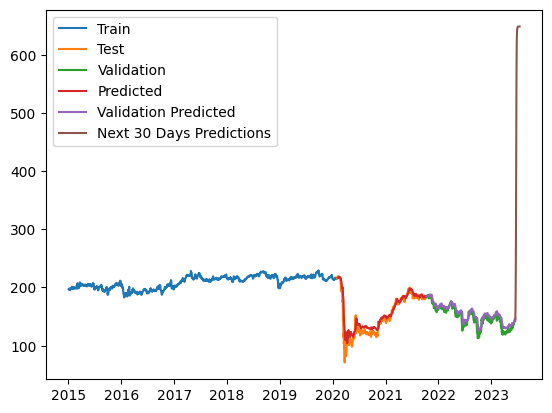

In [175]:
# Tạo danh sách ngày cho trục x
dates_train = df.index[:train_size]
dates_test = df.index[train_size:train_size+test_size]
dates_val = df.index[train_size+test_size:train_size+test_size+val_size]
dates_pred = df.index[train_size+lookback+horizon-1:train_size+test_size]
dates_pred_val = df.index[train_size+test_size+lookback+horizon-1:train_size+test_size+val_size]
dates_next30days = pd.date_range(start=df.index[-1], periods=num_predictions+1)[1:]


# Vẽ biểu đồ
plt.plot(dates_train, scaler.inverse_transform(train_data), label='Train')
plt.plot(dates_test, scaler.inverse_transform(test_data), label='Test')
plt.plot(dates_val, scaler.inverse_transform(val_data), label='Validation')
plt.plot(dates_pred, y_pred, label='Predicted')
plt.plot(dates_pred_val, y_pred_val, label='Validation Predicted')
plt.plot(dates_next30days, next30days_predictions, label='Next 30 Days Predictions')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.title('Stock Price Predictions')
plt.legend()
plt.show()